In [1]:
import numpy as np
import os
import librosa
import librosa.display
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.preprocessing
from scipy.signal import lfilter
from joblib import Parallel, delayed
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

In [2]:
df = pd.read_csv(r"C:\Users\jmdgo\Downloads\binary_labeled_dataset.csv")

In [3]:
value_counts = df['Stutter'].value_counts()
total_rows = df.shape[0]

percentage_per_class = (value_counts / total_rows) * 100

print(percentage_per_class)

0    60.677123
1    39.322877
Name: Stutter, dtype: float64


In [4]:
def extract_mfcc(audio_file, num_mfcc=40):
    audio, sr = librosa.load(audio_file, sr=None)
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=num_mfcc)
    mfccs_transposed = mfccs.T  # Transpose the MFCC matrix
    mfccs_flat = mfccs_transposed.flatten()  # Flatten the transposed MFCC matrix
    return mfccs_flat

In [5]:
def extract_zcr(audio_file, frame_length=2048, hop_length=512):
    audio, sr = librosa.load(audio_file, sr=None)
    zcr = librosa.feature.zero_crossing_rate(audio, frame_length=frame_length, hop_length=hop_length)
    return zcr.flatten()

In [6]:
def calculate_jitter(audio_file, frame_length=2048, hop_length=512):
    y, sr = librosa.load(audio_file, sr=None)
    f0, voiced_flag, voiced_probs = librosa.pyin(y, fmin=75, fmax=600)
    periods = 1 / f0[voiced_flag]
    periods[np.isnan(periods)] = 0
    period_diffs = np.diff(periods)
    jitter = np.mean(np.abs(period_diffs)) * 100 
    return jitter

In [7]:
def calculate_shimmer(audio_file, frame_length=2048, hop_length=512):
    y, sr = librosa.load(audio_file, sr=None)
    f0, voiced_flag, _ = librosa.pyin(y, fmin=75, fmax=600)
    rms = librosa.feature.rms(y=y, frame_length=frame_length, hop_length=hop_length)[0]
    voiced_rms = rms[voiced_flag]
    voiced_rms[np.isnan(voiced_rms)] = 0
    shimmer = np.mean(np.abs(np.diff(voiced_rms))) / np.mean(voiced_rms) * 100
    return shimmer

In [8]:
audio_files = df['audio_path'] 
labels = df['Interjection']

In [9]:
df_Interjection = df[['audio_path', 'Interjection']]

In [10]:
df_Interjection_0 = df[(df['Prolongation']==0) & 
                        (df['Block']==0) & 
                        (df['Interjection']==0) & 
                        (df['WordRep']==0) & 
                        (df['SoundRep']==0) &
                        (df['NoStutteredWords']==1)]


In [11]:
df_Interjection_1 = df_Interjection[df_Interjection['Interjection']==1]
df_Interjection_0 = df_Interjection_0[['audio_path', 'Interjection']]

In [12]:
df_Interjection_1.shape

(4836, 2)

In [13]:
df_Interjection_0_sampled = df_Interjection_0.sample(df_Interjection_1.shape[0])

In [14]:
df_Interjection_0_sampled.shape

(4836, 2)

In [15]:
df_Interjection_data = pd.concat([df_Interjection_0_sampled, df_Interjection_1], ignore_index=True, axis=0)

In [16]:
df_Interjection_data.shape

(9672, 2)

In [17]:
df_Interjection.head(2)

,audio_path,Interjection
0,C:\Users\jmdgo\Downloads\extracted_clips\extra...,0
1,C:\Users\jmdgo\Downloads\extracted_clips\extra...,0


In [18]:
value_counts = df_Interjection_data['Interjection'].value_counts()
total_rows = df_Interjection_data.shape[0]

percentage_per_class = (value_counts / total_rows) * 100

print(percentage_per_class)

0    50.0
1    50.0
Name: Interjection, dtype: float64


In [19]:
X = np.array(df_Interjection_data['audio_path'])
y = np.array(df_Interjection_data['Interjection'])

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=40, stratify = y)

In [21]:
# Function to merge features
def merge_features(mfcc, zcr, jitter, shimmer):
    return np.hstack((mfcc, zcr, jitter, shimmer))

# Extract MFCC features for training set
mfcc_features_train = Parallel(n_jobs=-1)(delayed(extract_mfcc)(audio_file) for audio_file in X_train)
mfcc_features_test = Parallel(n_jobs=-1)(delayed(extract_mfcc)(audio_file) for audio_file in X_test)

# Extract ZCR features for training set
zcr_features_train = Parallel(n_jobs=-1)(delayed(extract_zcr)(audio_file) for audio_file in X_train)
zcr_features_test = Parallel(n_jobs=-1)(delayed(extract_zcr)(audio_file) for audio_file in X_test)

# Extract Jitter features for training set
jitter_features_train = Parallel(n_jobs=-1)(delayed(calculate_jitter)(audio_file) for audio_file in X_train)
jitter_features_test = Parallel(n_jobs=-1)(delayed(calculate_jitter)(audio_file) for audio_file in X_test)

# Fill NaN values with zero for Jitter features
jitter_features_train = [np.nan_to_num(jitter, nan=0.0) for jitter in jitter_features_train]
jitter_features_test = [np.nan_to_num(jitter, nan=0.0) for jitter in jitter_features_test]

# Extract Shimmer features for training set
shimmer_features_train = Parallel(n_jobs=-1)(delayed(calculate_shimmer)(audio_file) for audio_file in X_train)
shimmer_features_test = Parallel(n_jobs=-1)(delayed(calculate_shimmer)(audio_file) for audio_file in X_test)

# Fill NaN values with zero for Shimmer features
shimmer_features_train = [np.nan_to_num(shimmer, nan=0.0) for shimmer in shimmer_features_train]
shimmer_features_test = [np.nan_to_num(shimmer, nan=0.0) for shimmer in shimmer_features_test]

# Merge features for training data
merged_features_train = [merge_features(mfcc, zcr, jitter, shimmer) for mfcc, zcr, jitter, shimmer in zip(mfcc_features_train, zcr_features_train, jitter_features_train, shimmer_features_train)]

# Merge features for test data
merged_features_test = [merge_features(mfcc, zcr, jitter, shimmer) for mfcc, zcr, jitter, shimmer in zip(mfcc_features_test, zcr_features_test, jitter_features_test, shimmer_features_test)]

In [22]:
def merge_features(mfcc, zcr, jitter, shimmer):
    return np.hstack((mfcc, zcr, jitter, shimmer))

# Merge features for training data
merged_features_train = [merge_features(mfcc, zcr, jitter, shimmer) for mfcc, zcr, jitter, shimmer in zip(mfcc_features_train, zcr_features_train, jitter_features_train, shimmer_features_train)]

# Merge features for test data
merged_features_test = [merge_features(mfcc, zcr, jitter, shimmer) for mfcc, zcr, jitter, shimmer in zip(mfcc_features_test, zcr_features_test, jitter_features_test, shimmer_features_test)]


In [23]:
len(merged_features_train)

6770

In [24]:
len(merged_features_test)

2902

In [25]:
y_train_series = pd.Series(y_train)
y_test_series = pd.Series(y_test)

# Count the occurrences of each unique value in y_train
train_distribution = y_train_series.value_counts()

# Count the occurrences of each unique value in y_test
test_distribution = y_test_series.value_counts()

print("Distribution of 0s and 1s in y_train:")
print(train_distribution)

print("\nDistribution of 0s and 1s in y_test:")
print(test_distribution)

Distribution of 0s and 1s in y_train:
0    3385
1    3385
dtype: int64

Distribution of 0s and 1s in y_test:
1    1451
0    1451
dtype: int64


# Random Forest

## searching for the best hyperparameters

In [28]:
param_grid_rf = {
    'n_estimators': [100, 300, 500, 800],
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 6, 10]
}

In [29]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

In [30]:
random_search_rf = RandomizedSearchCV(estimator=rf, param_distributions=param_grid_rf, n_iter=50, cv=5, random_state=42)

In [31]:
random_search_rf.fit(merged_features_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
                   n_iter=50,
                   param_distributions={'max_depth': [5, 10, 15, 20],
                                        'min_samples_leaf': [1, 2, 4, 6, 10],
                                        'min_samples_split': [2, 5, 10, 20],
                                        'n_estimators': [100, 300, 500, 800]},
                   random_state=42)

In [32]:
best_params_rf = random_search_rf.best_params_
best_model_rf = random_search_rf.best_estimator_

print("Best parameters (Random Forest):", best_params_rf)

print(f"Best score (Random Forest): {random_search_rf.best_score_*100:.4f}%")

Best parameters (Random Forest): {'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 15}
Best score (Random Forest): 66.8095%


## evaluate the best model

In [30]:
y_pred_rf = best_model_rf.predict(merged_features_test)

In [52]:
from sklearn.metrics import accuracy_score, classification_report

In [53]:
accuracy_score(y_test,y_pred_rf)

0.6540317022742936

In [54]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.65      0.67      0.66      1451
           1       0.66      0.64      0.65      1451

    accuracy                           0.65      2902
   macro avg       0.65      0.65      0.65      2902
weighted avg       0.65      0.65      0.65      2902



In [26]:
best_model_rf = RandomForestClassifier(n_jobs=-1, n_estimators=500, min_samples_split=10, min_samples_leaf=4, max_depth=15)
best_model_rf.fit(merged_features_train, y_train)

RandomForestClassifier(max_depth=15, min_samples_leaf=4, min_samples_split=10,
                       n_estimators=500, n_jobs=-1)

In [27]:
from sklearn.metrics import roc_curve, auc
def plot_roc(best_model, model_name):
    predicted_probabilities = best_model.predict_proba(merged_features_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, predicted_probabilities)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Interjection - {model_name} - ROC Curve')
    plt.legend(loc="lower right")
    plt.savefig(f'ROC_{model_name}.png')
    plt.show()

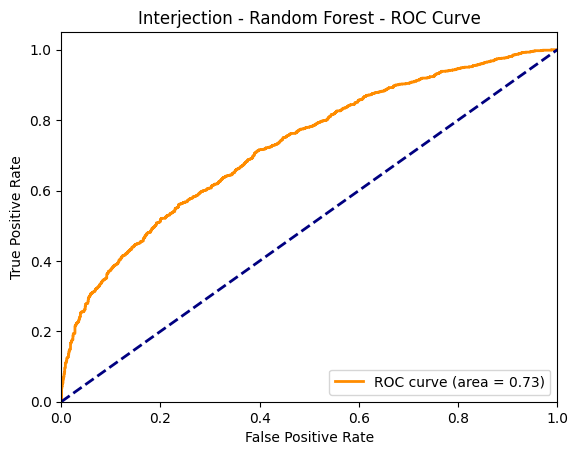

In [28]:
plot_roc(best_model_rf, 'Random Forest')

In [31]:
verifyer_rf = pd.DataFrame([X_test, y_pred_rf, y_test]).T

In [32]:
verifyer_rf.columns = ['audio', 'y_pred', 'y_test']

In [33]:
verifyer_rf[(verifyer_rf['y_pred']==0) & (verifyer_rf['y_test']==0)]

,audio,y_pred,y_test
1,C:\Users\jmdgo\Downloads\extracted_clips\extra...,0,0
2,C:\Users\jmdgo\Downloads\extracted_clips\extra...,0,0
3,C:\Users\jmdgo\Downloads\extracted_clips\extra...,0,0
6,C:\Users\jmdgo\Downloads\extracted_clips\extra...,0,0
7,C:\Users\jmdgo\Downloads\extracted_clips\extra...,0,0
...,...,...,...
2888,C:\Users\jmdgo\Downloads\extracted_clips\extra...,0,0
2891,C:\Users\jmdgo\Downloads\extracted_clips\extra...,0,0
2894,C:\Users\jmdgo\Downloads\extracted_clips\extra...,0,0
2898,C:\Users\jmdgo\Downloads\extracted_clips\extra...,0,0


In [34]:
verifyer_rf[(verifyer_rf['y_pred']==1) & (verifyer_rf['y_test']==1)]

,audio,y_pred,y_test
4,C:\Users\jmdgo\Downloads\extracted_clips\extra...,1,1
10,C:\Users\jmdgo\Downloads\extracted_clips\extra...,1,1
11,C:\Users\jmdgo\Downloads\extracted_clips\extra...,1,1
12,C:\Users\jmdgo\Downloads\extracted_clips\extra...,1,1
17,C:\Users\jmdgo\Downloads\extracted_clips\extra...,1,1
...,...,...,...
2883,C:\Users\jmdgo\Downloads\extracted_clips\extra...,1,1
2889,C:\Users\jmdgo\Downloads\extracted_clips\extra...,1,1
2895,C:\Users\jmdgo\Downloads\extracted_clips\extra...,1,1
2896,C:\Users\jmdgo\Downloads\extracted_clips\extra...,1,1


In [35]:
verifyer_rf

,audio,y_pred,y_test
0,C:\Users\jmdgo\Downloads\extracted_clips\extra...,0,1
1,C:\Users\jmdgo\Downloads\extracted_clips\extra...,0,0
2,C:\Users\jmdgo\Downloads\extracted_clips\extra...,0,0
3,C:\Users\jmdgo\Downloads\extracted_clips\extra...,0,0
4,C:\Users\jmdgo\Downloads\extracted_clips\extra...,1,1
...,...,...,...
2897,C:\Users\jmdgo\Downloads\extracted_clips\extra...,1,0
2898,C:\Users\jmdgo\Downloads\extracted_clips\extra...,0,0
2899,C:\Users\jmdgo\Downloads\extracted_clips\extra...,0,0
2900,C:\Users\jmdgo\Downloads\extracted_clips\extra...,1,1


In [36]:
verifyer_rf.to_csv("predicted_Interjection.csv")

In [37]:
import pickle
file_path = "randomforest_Interjection.pkl"

with open(file_path, 'wb') as file:
    pickle.dump(best_model_rf, file)

In [38]:
test_rf = pd.DataFrame([X_test, y_test, y_pred_rf]).T
test_rf.columns = ['X_test', 'y_test', 'y_pred']

In [39]:
test_rf.to_csv("test_rf.csv")

# Decision Tree

In [63]:
param_grid_dt = {
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 6, 10]
}

In [41]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=42)

In [64]:
random_search_dt = RandomizedSearchCV(estimator=dt, param_distributions=param_grid_dt, n_iter=50, cv=5, random_state=42)

In [65]:
random_search_dt.fit(merged_features_train, y_train)

RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=50,
                   param_distributions={'max_depth': [5, 10, 15, 20],
                                        'min_samples_leaf': [1, 2, 4, 6, 10],
                                        'min_samples_split': [2, 5, 10, 20]},
                   random_state=42)

In [66]:
best_params_dt = random_search_dt.best_params_
best_model_dt = random_search_dt.best_estimator_

print("Best parameters (Decision Tree):", best_params_dt)

print(f"Best score (Decision Tree): {random_search_dt.best_score_*100:.4f}%")

Best parameters (Decision Tree): {'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 5}
Best score (Decision Tree): 57.6219%


In [46]:
y_pred_dt = best_model_dt.predict(merged_features_test)

In [55]:
accuracy_score(y_test, y_pred_dt)

0.5671950379048932

In [56]:
print(classification_report(y_test, y_pred_dt))

              precision    recall  f1-score   support

           0       0.56      0.59      0.58      1451
           1       0.57      0.54      0.56      1451

    accuracy                           0.57      2902
   macro avg       0.57      0.57      0.57      2902
weighted avg       0.57      0.57      0.57      2902



In [42]:
best_model_dt = DecisionTreeClassifier(min_samples_split=10, min_samples_leaf=4, max_depth=5)
best_model_dt.fit(merged_features_train, y_train)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=4, min_samples_split=10)

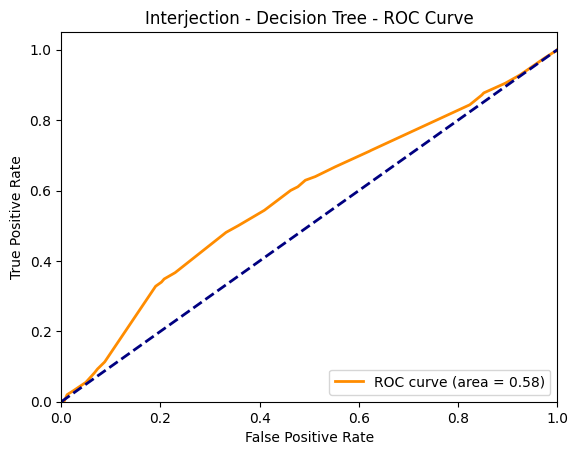

In [43]:
plot_roc(best_model_dt,'Decision Tree')

In [44]:
file_path = "decisiontree_Interjection.pkl"

with open(file_path, 'wb') as file:
    pickle.dump(best_model_dt, file)

In [47]:
verifyer_dt = pd.DataFrame([X_test, y_pred_dt, y_test]).T
verifyer_dt.columns = ['audio', 'y_pred', 'y_test']
verifyer_dt.to_csv("predicted_dt_Interjection.csv")
test_dt = pd.DataFrame([X_test, y_test, y_pred_dt]).T
test_dt.columns = ['X_test', 'y_test', 'y_pred']
test_dt.to_csv("test_dt.csv")

# k-Nearest Neighbors (kNN)

In [74]:
param_grid_knn = {
    'n_neighbors': np.arange(1, 22, 2),
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': [1, 2]
}

In [48]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_jobs=-1)

In [75]:
random_search_knn = RandomizedSearchCV(estimator=knn, param_distributions=param_grid_knn, n_iter=50, cv=5, random_state=42)

In [76]:
random_search_knn.fit(merged_features_train, y_train)

RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(n_jobs=-1), n_iter=50,
                   param_distributions={'algorithm': ['auto', 'ball_tree',
                                                      'kd_tree', 'brute'],
                                        'n_neighbors': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21]),
                                        'p': [1, 2],
                                        'weights': ['uniform', 'distance']},
                   random_state=42)

In [77]:
best_params_knn = random_search_knn.best_params_
best_model_knn = random_search_knn.best_estimator_

print("Best parameters (KNN):", best_params_knn)

print(f"Best score (KNN): {random_search_knn.best_score_*100:.4f}%")

Best parameters (KNN): {'weights': 'distance', 'p': 1, 'n_neighbors': 19, 'algorithm': 'brute'}
Best score (KNN): 62.7179%


In [50]:
y_pred_knn = best_model_knn.predict(merged_features_test)

In [57]:
accuracy_score(y_test, y_pred_knn)

0.638869745003446

In [58]:
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           0       0.63      0.69      0.66      1451
           1       0.65      0.59      0.62      1451

    accuracy                           0.64      2902
   macro avg       0.64      0.64      0.64      2902
weighted avg       0.64      0.64      0.64      2902



In [49]:
best_model_knn = KNeighborsClassifier(n_jobs=-1, weights='distance', p=1, n_neighbors=19, algorithm='brute')
best_model_knn.fit(merged_features_train, y_train)

KNeighborsClassifier(algorithm='brute', n_jobs=-1, n_neighbors=19, p=1,
                     weights='distance')

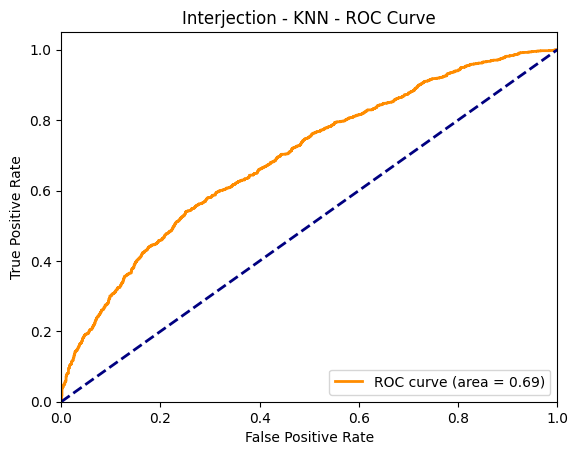

In [59]:
plot_roc(best_model_knn, 'KNN')

In [60]:
file_path = "knn_Interjection.pkl"

with open(file_path, 'wb') as file:
    pickle.dump(best_model_knn, file)

In [61]:
verifyer_knn = pd.DataFrame([X_test, y_pred_knn, y_test]).T
verifyer_knn.columns = ['audio', 'y_pred', 'y_test']
verifyer_knn.to_csv("predicted_knn_Interjection.csv")
test_knn = pd.DataFrame([X_test, y_test, y_pred_knn]).T
test_knn.columns = ['X_test', 'y_test', 'y_pred']
test_knn.to_csv("test_knn.csv")

# Support Vector Classifier (SVC)

In [85]:
param_grid_svc = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto']
}

In [62]:
from sklearn.svm import SVC
svc = SVC()

In [86]:
random_search_svc = RandomizedSearchCV(estimator=svc, param_distributions=param_grid_svc, n_iter=50, cv=5, random_state=42)

In [87]:
random_search_svc.fit(merged_features_train, y_train)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 32 is smaller than n_iter=50. Running 32 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=5, estimator=SVC(), n_iter=50,
                   param_distributions={'C': [0.1, 1, 10, 100],
                                        'gamma': ['scale', 'auto'],
                                        'kernel': ['linear', 'poly', 'rbf',
                                                   'sigmoid']},
                   random_state=42)

In [88]:
best_params_svc = random_search_svc.best_params_
best_model_svc = random_search_svc.best_estimator_

print("Best parameters (SVC):", best_params_svc)

print(f"Best score (SVC): {random_search_svc.best_score_*100:.4f}%")

Best parameters (SVC): {'kernel': 'rbf', 'gamma': 'scale', 'C': 10}
Best score (SVC): 65.9527%


In [66]:
y_pred_svc = best_model_svc.predict(merged_features_test)

In [67]:
accuracy_score(y_test, y_pred_svc)

0.6598897312198484

In [68]:
print(classification_report(y_test, y_pred_svc))

              precision    recall  f1-score   support

           0       0.66      0.66      0.66      1451
           1       0.66      0.66      0.66      1451

    accuracy                           0.66      2902
   macro avg       0.66      0.66      0.66      2902
weighted avg       0.66      0.66      0.66      2902



In [63]:
best_model_svc = SVC(kernel='rbf', gamma='scale', C=10, probability=True)
best_model_svc.fit(merged_features_train, y_train)

SVC(C=10, probability=True)

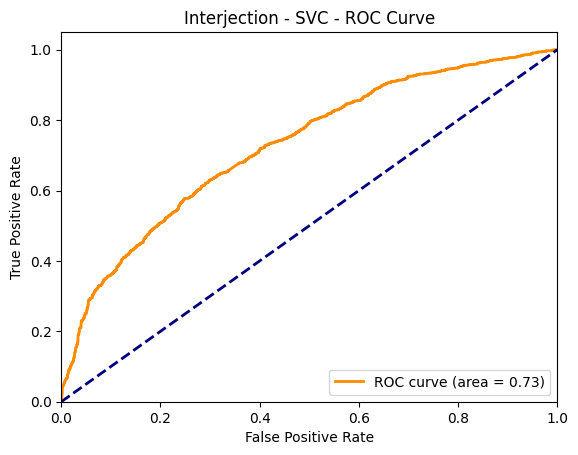

In [64]:
plot_roc(best_model_svc, 'SVC')

In [69]:
file_path = "svc_Interjection.pkl"

with open(file_path, 'wb') as file:
    pickle.dump(best_model_svc, file)

In [70]:
verifyer_svc = pd.DataFrame([X_test, y_pred_svc, y_test]).T
verifyer_svc.columns = ['audio', 'y_pred', 'y_test']
verifyer_svc.to_csv("predicted_svc_Interjection.csv")
test_svc = pd.DataFrame([X_test, y_test, y_pred_svc]).T
test_svc.columns = ['X_test', 'y_test', 'y_pred']
test_svc.to_csv("test_svc.csv")

# Naive Bayes

In [71]:
from sklearn.model_selection import cross_validate
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()

In [72]:
# Perform cross-validation
cv_results = cross_validate(nb, merged_features_train, y_train, cv=5,
                            scoring=['accuracy', 'precision', 'recall', 'f1'],
                            return_estimator=True)

In [73]:
cv_results

{'fit_time': array([0.63154268, 0.59833932, 0.52925181, 0.35402155, 0.32678509]),
 'score_time': array([0.17716026, 0.1733284 , 0.16715384, 0.11770153, 0.11913753]),
 'estimator': [GaussianNB(),
  GaussianNB(),
  GaussianNB(),
  GaussianNB(),
  GaussianNB()],
 'test_accuracy': array([0.58345643, 0.58567208, 0.59305761, 0.59527326, 0.58567208]),
 'test_precision': array([0.59560068, 0.59666667, 0.61170213, 0.60876897, 0.59385113]),
 'test_recall': array([0.51994092, 0.52880355, 0.50960118, 0.53323486, 0.54209749]),
 'test_f1': array([0.55520505, 0.56068912, 0.55600322, 0.56850394, 0.56679537])}

In [74]:
# Extract the best model based on accuracy
best_model_index = cv_results['test_accuracy'].argmax()
best_model_nb = cv_results['estimator'][best_model_index]

In [75]:
best_model_index

3

In [76]:
best_model_nb.fit(merged_features_train, y_train)

GaussianNB()

In [77]:
y_pred_nb = best_model_nb.predict(merged_features_test)

In [78]:
accuracy_score(y_test, y_pred_nb)

0.5796002756719504

In [79]:
print(classification_report(y_test, y_pred_nb))

              precision    recall  f1-score   support

           0       0.57      0.64      0.60      1451
           1       0.59      0.52      0.55      1451

    accuracy                           0.58      2902
   macro avg       0.58      0.58      0.58      2902
weighted avg       0.58      0.58      0.58      2902



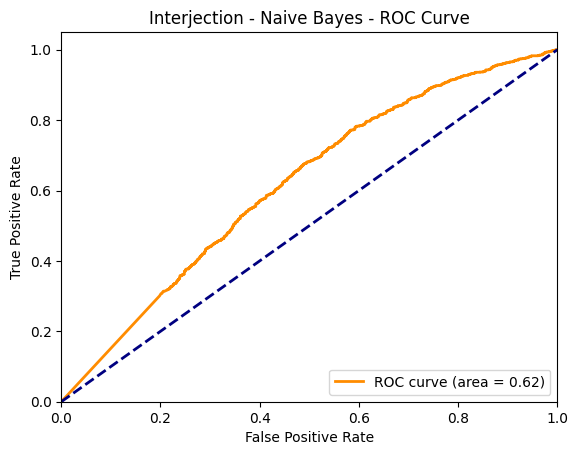

In [80]:
plot_roc(best_model_nb, 'Naive Bayes')

In [81]:
file_path = "naivebayes_Interjection.pkl"

with open(file_path, 'wb') as file:
    pickle.dump(best_model_nb, file)

In [82]:
verifyer_nb = pd.DataFrame([X_test, y_pred_nb, y_test]).T
verifyer_nb.columns = ['audio', 'y_pred', 'y_test']
verifyer_nb.to_csv("predicted_nb_Interjection.csv")
test_nb = pd.DataFrame([X_test, y_test, y_pred_nb]).T
test_nb.columns = ['X_test', 'y_test', 'y_pred']
test_nb.to_csv("test_nb.csv")

# Logistic Regression

In [83]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(n_jobs=-1)
lr.fit(merged_features_train, y_train)

LogisticRegression(n_jobs=-1)

In [84]:
# Perform cross-validation
cv_results = cross_validate(lr, merged_features_train, y_train, cv=5,
                            scoring=['accuracy', 'precision', 'recall', 'f1'],
                            return_estimator=True)

In [85]:
cv_results

{'fit_time': array([3.52314019, 3.5237844 , 3.47405195, 3.53377366, 3.80234313]),
 'score_time': array([0.03406405, 0.03242731, 0.03571796, 0.04161191, 0.04108548]),
 'estimator': [LogisticRegression(n_jobs=-1),
  LogisticRegression(n_jobs=-1),
  LogisticRegression(n_jobs=-1),
  LogisticRegression(n_jobs=-1),
  LogisticRegression(n_jobs=-1)],
 'test_accuracy': array([0.59970458, 0.5915805 , 0.61595273, 0.6351551 , 0.59675037]),
 'test_precision': array([0.602118  , 0.59309309, 0.61103253, 0.62726008, 0.60155039]),
 'test_recall': array([0.58788774, 0.58345643, 0.63810931, 0.6661743 , 0.57311669]),
 'test_f1': array([0.59491779, 0.58823529, 0.62427746, 0.64613181, 0.58698941])}

In [86]:
# Extract the best model based on accuracy
best_model_index = cv_results['test_accuracy'].argmax()
best_model_lr = cv_results['estimator'][best_model_index]

In [87]:
best_model_index

3

In [88]:
best_model_lr.fit(merged_features_train, y_train)

LogisticRegression(n_jobs=-1)

In [89]:
y_pred_lr = best_model_lr.predict(merged_features_test)

In [90]:
accuracy_score(y_test, y_pred_nb)

0.5796002756719504

In [91]:
print(classification_report(y_test, y_pred_nb))

              precision    recall  f1-score   support

           0       0.57      0.64      0.60      1451
           1       0.59      0.52      0.55      1451

    accuracy                           0.58      2902
   macro avg       0.58      0.58      0.58      2902
weighted avg       0.58      0.58      0.58      2902



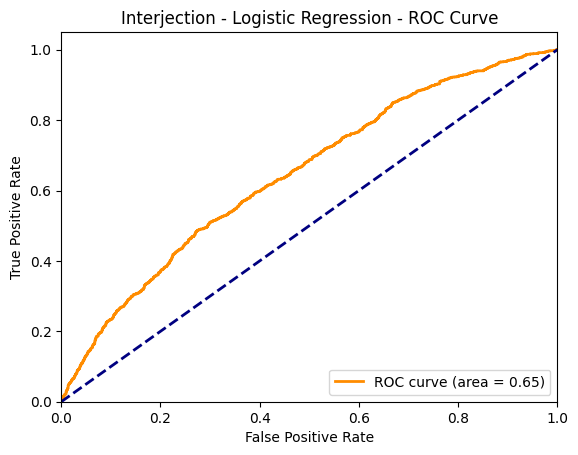

In [92]:
plot_roc(best_model_lr, 'Logistic Regression')

In [93]:
file_path = "logreg_Interjection.pkl"

with open(file_path, 'wb') as file:
    pickle.dump(lr, file)

In [94]:
verifyer_lr = pd.DataFrame([X_test, y_pred_lr, y_test]).T
verifyer_lr.columns = ['audio', 'y_pred', 'y_test']
verifyer_lr.to_csv("predicted_logreg_Interjection.csv")
test_lr = pd.DataFrame([X_test, y_test, y_pred_lr]).T
test_lr.columns = ['X_test', 'y_test', 'y_pred']
test_lr.to_csv("test_logreg.csv")

# Comparative Analysis of all the models 

In [95]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [96]:
models = ['Random Forest', 'Decision Tree', 'KNN', 'SVC', 'Naive Bayes', 'Logistic Regression']
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
best_models = [best_model_rf, best_model_dt, best_model_knn, best_model_svc, best_model_nb, best_model_lr]
y_preds = [y_pred_rf, y_pred_dt, y_pred_knn, y_pred_svc, y_pred_nb, y_pred_lr]

In [97]:
# Function to calculate evaluation metrics
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return accuracy, precision, recall, f1

In [98]:
# Calculate evaluation metrics for each model
for model, y_pred in zip(best_models, y_preds):
    accuracy, precision, recall, f1 = calculate_metrics(y_test, y_pred)
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

In [101]:
evaluation_df = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracy_scores,
    'Precision': precision_scores,
    'Recall': recall_scores,
    'F1 Score': f1_scores
})
print('Comparison of all ML models(Interjection): ')
evaluation_df

Comparison of all ML models(Interjection): 


,Model,Accuracy,Precision,Recall,F1 Score
0,Random Forest,0.654032,0.658174,0.640937,0.649441
1,Decision Tree,0.567195,0.570499,0.543763,0.556810
2,KNN,0.638870,0.654881,0.587181,0.619186
3,SVC,0.659890,0.661335,0.655410,0.658359
4,Naive Bayes,0.579600,0.591160,0.516196,0.551141
5,Logistic Regression,0.599242,0.597035,0.610613,0.603748


In [102]:
print(f'Highest Accuracy score of {np.max(accuracy_scores)*100:.2f}% with {models[np.argmax(accuracy_scores)]}')
print(f'Highest Precision score of {np.max(precision_scores)*100:.2f}% with {models[np.argmax(precision_scores)]}')
print(f'Highest Recall score of {np.max(recall_scores)*100:.2f}% with {models[np.argmax(recall_scores)]}')
print(f'Highest F1 score of {np.max(f1_scores)*100:.2f}% with {models[np.argmax(f1_scores)]}')

Highest Accuracy score of 65.99% with SVC
Highest Precision score of 66.13% with SVC
Highest Recall score of 65.54% with SVC
Highest F1 score of 65.84% with SVC
